# Slip on a planar fault in a halfspace

This is the first and simplest example of Tectosaur. Here, we'll solve for the halfspace surface displacement caused by a Gaussian slip field on a planar fault. we'll first solve the problem using Okada dislocations. Then, we will solve it using Tectosaur and compare the two solutions. 

To start out, let's import the necessary modules. We use standard scientific Python packages: `numpy`, `scipy`, `matplotlib`. The [`okada_wrapper` module](https://github.com/tbenthompson/okada_wrapper) is a simple Python wrapper around the original Okada Fortran code. Finally, import Tectosaur!

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsla

import okada_wrapper

import tectosaur as tct
tct.logger.setLevel(logging.INFO)

Now, let's make a mesh! Here, the `tct.make_rect` function produces a triangulated rectangle mesh, with `n` points on both the x and y dimensions and with the corners specified. And, we plot the mesh in the x-y plane just to make sure everything worked right! The plotting code might help understanding the layout of the mesh structure. The `surf` object is a tuple. The first element is the array of mesh points with shape `(n_points, n_dims = 3)`. The second element is the array of triangles with shape `(n_triangles, n_corners = 3)`.

pts shape (3721, 3)
tris shape (7200, 3)


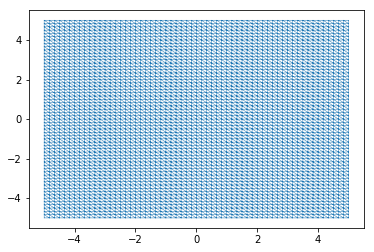

In [2]:
w = 5.0
n = 61
corners = [[-w, -w, 0], [-w, w, 0], [w, w, 0], [w, -w, 0]]
surf = tct.make_rect(n, n, corners)

print('pts shape', surf[0].shape)
print('tris shape', surf[1].shape)
plt.triplot(surf[0][:,0], surf[0][:,1], surf[1], linewidth = 0.5)
plt.show()

And we'll do the same thing in the x-z plane for the fault. 

In [3]:
fault_L = 1.0
top_depth = -0.5
n_fault = 15
fault_corners = [
    [-fault_L, 0, top_depth], [-fault_L, 0, top_depth - 1],
    [fault_L, 0, top_depth - 1], [fault_L, 0, top_depth]
]
fault = tct.make_rect(n_fault, n_fault, fault_corners)

And let's specify the physical setup of the problem. First off, we use a shear modulus of 1.0 and Poisson ratio of 0.25. While 1.0 is an absurdly small shear modulus, there is nothing numerically different between using a shear modulus of `1e0` and `1e10` -- it simply multiplies any stresses or tractions.

In [4]:
sm = 1.0
pr = 0.25

We specify and plot a Gaussian slip pulse centered at `(0.0, -1.0)`. 

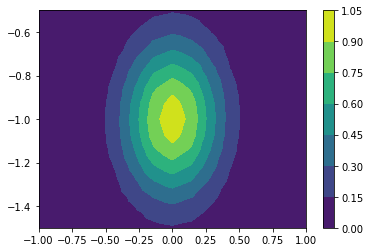

In [5]:
def gauss_slip_fnc(x, z):
    return np.exp(-(x ** 2 + (z + 1.0) ** 2) * 8.0)

pt_slip = gauss_slip_fnc(fault[0][:,0], fault[0][:,2])
plt.tricontourf(fault[0][:,0], fault[0][:,2], fault[1], pt_slip)
plt.colorbar()
plt.show()

Let's solve for the surface displacement using Okada dislocations. I discretize the fault into a 30x30 rectangular grid, and then for each observation point in the surface mesh, I loop over the fault elements and calculate the elastic effect. 

In [6]:
lam = 2 * sm * pr / (1 - 2 * pr)
alpha = (lam + sm) / (lam + 2 * sm)

okada_u = np.zeros((surf[0].shape[0], 3))
NX = 30
NY = 30
X_vals = np.linspace(-fault_L, fault_L, NX + 1)
Y_vals = np.linspace(-1.0, 0.0, NX + 1)
for i in range(surf[0].shape[0]):
    pt = surf[0][i, :]
    for j in range(NX):
        X1 = X_vals[j]
        X2 = X_vals[j+1]
        midX = (X1 + X2) / 2.0
        for k in range(NY):
            Y1 = Y_vals[k]
            Y2 = Y_vals[k+1]
            midY = (Y1 + Y2) / 2.0
            slip = gauss_slip_fnc(midX, midY + top_depth)

            [suc, uv, grad_uv] = okada_wrapper.dc3dwrapper(
                alpha, pt, -top_depth, 90.0,
                [X1, X2], [Y1, Y2], [slip, 0.0, 0.0]
            )

            if suc != 0:
                okada_u[i, :] = 0
            else:
                okada_u[i, :] += uv

Now, that we've set up and solved our problem using Okada dislocations, we get to solve using Tectosaur! We'll build up the integral equation and then solve using GMRES, an iterative linear solver. 

I'll do a broad strokes overview of the Symmetric Galerking Boundary Element Method (SGBEM) approach to solving this problem. To start, let's start from Somigliana's identity for a domain with a crack:

$$u(x) + \int_{S} T^{*}(x,y) u(y) dS + \int_{F} T^{*}(x,y) s(y) dF = \int_{S} U^*(x,y) t(y) dS$$

where $S$ is the free surface, $F$ is the fault, $u$ is the displacement, $s$ is the fault slip, $t$ is the surface traction and $U^*$ and $T^*$ are the respective Green's functions. 

We can simplify this equation given that we know $t = 0$ on $S$ and that $s$ on $F$ is given:

$$u(x) + \int_{S} T^{*}(x,y) u(y) dS + \int_{F} T^{*}(x,y) s(y) dF = 0$$

The form of the second two integrals is identical, so instead we can use a single integral:

$$u(x) + \int_{\hat{S}} T^{*}(x,y) \hat{u}(y) d\hat{S} = 0$$

where $\hat{S} = S \cup F$ and

$$\hat{u}(x) = \begin{cases}u(x)  & x \in S\\s(x) & x \in F\end{cases}$$

At the moment, we have an integral equation that gives us the displacement anywhere in the volume as a function of fault slip and surface displacement. We'd like to transform that to an integral equation that allows solving for the surface displacement from the fault slip. The first step is the enforce the integral equation on the surface multiplied by a test function:

$$\int_{S}\phi(x)\big[\frac{u(x)}{2} + \int_{\hat{S}} T^{*}(x,y) \hat{u}(y) d\hat{S}\big]dS = 0$$

(For reasons to do with boundary limits, we gain a factor of $\frac{1}{2}$.) 

Then, discretizing all the fields with linear basis functions ($\phi_i(x)$) over a triangulated mesh and choosing the test functions to be equal to those basis functions results in the standard SGBEM. We get

$$\begin{align}M_{ij}u_{j} + T_{ik}\hat{u}_k = 0\\ M_{ij} = \int_{S}\phi_i(x)\phi_j(x)dS \\ T_{ik} = \int_S\phi_i(x)\int_{\hat{S}}T^*(x,y)\phi_k(y) d\hat{S} \\ \hat{u}(x) = \sum_{j}\phi_j(x)\hat{u}_j\end{align}$$

To put this into practice, we'll create these two operators using Tectosaur. First we'll create the $T$ operator.

In [7]:
full_mesh = tct.concat(surf, fault)
T = tct.RegularizedSparseIntegralOp(
    8, # The coincident quadrature order
    8, # The edge adjacent quadrature order
    8, # The vertex adjacent quadrature order
    2, # The farfield quadrature order
    5, # The nearfield quadrature order
    2.5, # The element length factor to separate near from farfield.
    'elasticRT3', # The Green's function to integrate
    'elasticRT3', #...
    [sm, pr], # The material parameters (shear modulus, poisson ratio)
    full_mesh[0], # The mesh points
    full_mesh[1], # The mesh triangles
    np.float32,   # The float type to use. float32 is much faster on most GPUs
    
    # Finally, do we use a direct (dense) farfield operator or do we use the Fast Multipole Method?
    farfield_op_type = tct.TriToTriDirectFarfieldOp 
    #farfield_op_type = FMMFarfieldOp(mac = 4.5, pts_per_cell = 100)
)

[40640:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0


Creating the $M$ "mass" operator is much simpler. We simply provide a Gauss quadrature order and the mesh.

In [8]:
mass = tct.MassOp(3, full_mesh[0], full_mesh[1])

Let's check out the matrix. It's very sparse! That's because $\phi_i(x)\phi_j(x)$ is only nonzero when the two basis functions are defined on the same triangle.

In [9]:
mass.mat

<68328x68328 sparse matrix of type '<class 'numpy.float64'>'
	with 204984 stored elements in Compressed Sparse Row format>

Wait, why didn't we look at the matrix for `T`? That's because it's partially a matrix-free operator representation. The nearfield is stored in a sparse matrix form. But, the farfield portions of the matrix are never stored. Because we can use a very low order quadrature to generate the farfield elements, the memory bandwidth requirements of storing those matrix elements are greater than the computational cost of recomputing each element every time it's needed. This is particularly true because we make heavy of GPUs where doing enormous amounts of simple arithmetic is very computationally cheap. A nice side effect of this design choice is that Tectosaur doesn't use very much RAM!

Ok, let's put together the mass and T operators into a single operator. Because the T operator is matrix free, we have to use `SumOp` and `MultOp` so that the summation and multiplication is done whenever a matrix vector product is needed, rather than right now on the matrix elements. 

In [10]:
lhs = tct.SumOp([T, tct.MultOp(mass, 0.5)])

Next, we need to set up the boundary condition on the fault. We already have the `gauss_slip_fnc` for fault slip! The question then is how to calculate the coefficients of the basis functions, $\hat{u}_j\phi_j(x)$. For linear basis functions, we can just evaluate `gauss_slip_fnc` at the corners of each triangle. The values at the corners are the degrees of freedom (DOFs). 

We'll calculate the slip for each DOF in the mesh. And we create a list of boundary conditions constraints to impose on our linear system using `tct.all_bc_constraints`.

In [11]:
n_surf_tris = surf[1].shape[0]
n_fault_tris = fault[1].shape[0]
fault_tris = full_mesh[1][n_surf_tris:]
dof_pts = full_mesh[0][fault_tris]
x = dof_pts[:,:,0]
z = dof_pts[:,:,2]
slip = np.zeros((fault_tris.shape[0], 3, 3))
slip[:,:,0] = gauss_slip_fnc(x, z)
bc_cs = tct.all_bc_constraints(
    n_surf_tris, # The first triangle index to apply BCs to. The first fault triangle is at index `n_surf_tris`.
    n_surf_tris + n_fault_tris, # The last triangle index to apply BCs to.
    slip.flatten() # The BC vector should be n_tris * 9 elements long. 
)

Because we are using a linear basis for the displacement on the free surface, there are several DOFs for most points in the mesh -- each triangle that touches a point has a DOF at that point. We'd like to impose continuity of displacement on the free surface, which requires equality between all the DOFs that share a point. But, we also need to ensure that there's a discontinuity across the fault. So, we also pass information about the fault mesh!

In [12]:
continuity_cs = tct.continuity_constraints(
    full_mesh[0], # The mesh points. 
    full_mesh[1], # The mesh triangles
    n_surf_tris # How many surface triangles are there? The triangles are expected to be arranged so that the surface triangles come first. The remaining triangles are assumed to be fault triangles.
)

So, what do we do with all these constraints? We map from the original unconstrained DOFs to a new set of constrained DOFs. The `tct.build_constraint_matrix` function uniquely defines a new (smaller) set of DOFs and constructs a matrix to transform from one set of DOFs to the another. Suppose we have 2000 original unconstrained DOFs, and 700 independent constraints. There will be 1300 constrained DOFs. So, the constraint matrix `cm` will be shaped `(2000, 1300)`. If any of those constraints have a non-zero constant offset (e.g. $x + y = 3$), then the `c_rhs` vector will contain those values. To transform from constrained DOFs to unconstrained DOFs: `cm.dot(x) + c_rhs`. So, if we start out with the linear system:

$$Ax = b$$

then in terms of the constrained DOFs, we have

$$A(Cy + r) = b$$
where $C$ is the constraint matrix, `cm` and $r$ is the vector of offsets, `c_rhs`. Next, we gain regain symmetry and square matrices by multiplying by $C^T$: 

$$C^TA(Cy + r) = C^Tb$$

And rearranging, the final constrained linear system will be:

$$C^TACy = C^Tb - C^TAr$$

These next few lines construct this constrained linear system. First, $C^Tb = 0$ for this problem, so we ignore that term. What's left?

Building $C$:

In [13]:
cs = bc_cs + continuity_cs
cm, c_rhs, _ = tct.build_constraint_matrix(cs, lhs.shape[1])

And building $C^TAr$:

In [14]:
rhs_constrained = cm.T.dot(-lhs.dot(c_rhs))

And things are getting exciting! Before we solve the linear system, we provide `scipy.sparse.linalg` with the info needed for our custom matrix vector product implementation. 

In [15]:
def mv(v, it = [0]):
    it[0] += 1
    print('iteration # ' + str(it[0]))
    return cm.T.dot(lhs.dot(cm.dot(v)))
n = rhs_constrained.shape[0]
A = spsla.LinearOperator((n, n), matvec = mv)

iteration # 1
iteration # 2


And solve!

In [16]:
gmres_out = spsla.gmres(
    A, rhs_constrained, tol = 1e-6, restart = 200, 
    callback = lambda R: print('residual: ', str(R))
)

iteration # 3
iteration # 4
residual:  0.146275628084712
iteration # 5
residual:  0.03594669983764868
iteration # 6
residual:  0.008053313543958236
iteration # 7
residual:  0.004458098908899483
iteration # 8
residual:  0.002113584121039492
iteration # 9
residual:  0.001376742004737391
iteration # 10
residual:  0.0008771696041539747
iteration # 11
residual:  0.00028013245929053393
iteration # 12
residual:  0.00015880583694272208
iteration # 13
residual:  0.00010717697267516745
iteration # 14
residual:  7.924078780641671e-05
iteration # 15
residual:  6.039030458347333e-05
iteration # 16
residual:  4.214737696969395e-05
iteration # 17
residual:  2.781313464247928e-05
iteration # 18
residual:  1.6604794672362767e-05
iteration # 19
residual:  1.228822867097769e-05
iteration # 20
residual:  9.318223348877133e-06
iteration # 21
residual:  6.497530589779632e-06
iteration # 22
residual:  4.506429483087589e-06
iteration # 23
residual:  3.3334278530578657e-06
iteration # 24
residual:  2.332973316

And the last step is to calculate the unconstrained solution from the constrained solution.

In [17]:
soln = cm.dot(gmres_out[0]) + c_rhs

You did it! You solved for the surface displacement with Tectosaur!!!

Let's plot up the solution. I want to make some `matplotlib.tricontour` plots. To do that, I need values for each point rather than for each triangle vertex. So, we convert from the solution DOFs to point values using the triangle array as the mapping.

In [18]:
tct_u = np.zeros((full_mesh[0].shape[0], 3))
tct_u[full_mesh[1]] = soln.reshape((-1,3,3))

Also, to easily plot both the Tectosaur and Okada solutions, I extend the Okada solution with zeros so that it has the same length as the Tectosaur solution (the total number of points in the full fault + surface mesh, not just the number of points in the surface mesh).

In [19]:
okada_u = np.vstack((okada_u, np.zeros((full_mesh[0].shape[0] - surf[0].shape[0], 3)))) 

A quick function to plot all three components of the displacement.

In [20]:
surf_pt_idxs = np.unique(full_mesh[1][:n_surf_tris])
def plot(pt_f):
    surf_pt_f = pt_f[surf_pt_idxs]
    min_f = np.min(surf_pt_f, axis = 0)
    max_f = np.max(surf_pt_f, axis = 0)

    plt.figure(figsize = (14, 4))
    for d in range(3):
        levels = np.linspace(-max_f[d], max_f[d], 11)
        plt.subplot(1, 3, d + 1)
        cntf = plt.tricontourf(
            full_mesh[0][:,0], full_mesh[0][:,1], full_mesh[1][:n_surf_tris], 
            pt_f[:,d], levels = levels
        )
        plt.colorbar(cntf)
    plt.show()

The match is very nice!

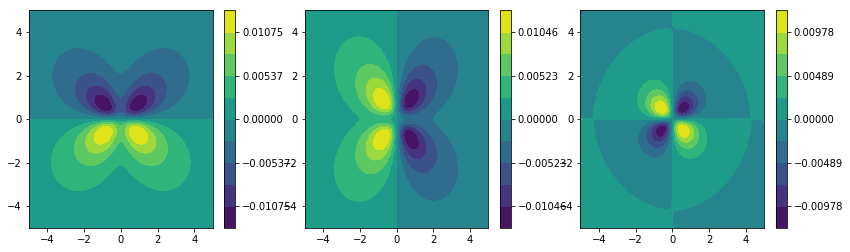

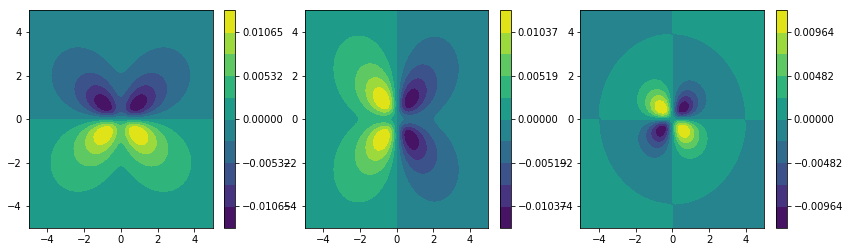

In [21]:
plot(tct_u)
plot(okada_u)

Let's plot the difference.

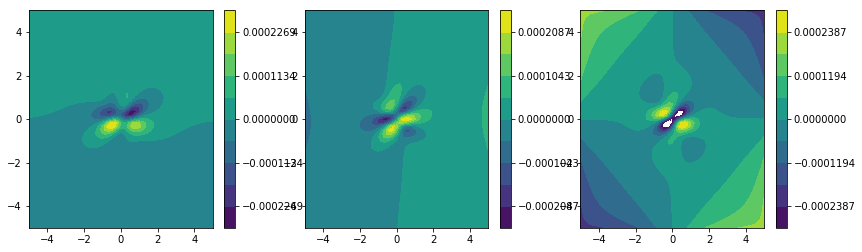

In [22]:
diff = tct_u - okada_u
plot(diff)

It's small and largest near the fault where a finer discretization would help resolve the large displacement gradients. You can also see there's some larger errors near the edge of the surface in the $u_z$ component. That's because we're trying to match Okada dislocations, which assume an infinite planar free surface, with a finite planar free surface. We could minimize that component of the error by increasing the size of the surface mesh. However, for practical Earth Science problems where 1\% error is acceptable, using a free surface that is 2-5x the fault length seems sufficient. 

Alright, we're all done here. We've replicated the surface displacement results of using Okada dislocation by using a very different type of BEM based on numerical integration and linear basis functions!